## Visualize the trajectory

The first version of the graph is built with plotly to add interaction, allowing to check the position of points and use the sliders to offset the trajectories if need be.

The second version uses matplotlib to generate a static plot that looks better when exported.

To run this code, you first need to generate datapoints from main.py

In [5]:
import os
import glob
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, IntSlider, IntText, HBox, VBox, Button, Output
import numpy as np
import plotly.io as pio

output_dir = './trajectories/vid220' #Where the files are 

files = sorted(glob.glob(os.path.join(output_dir, '*.txt')))
missing = []
DEFAULT_OFFSETS = [0,93,165] #Default offets between the files

dataframes = []
for csv, color in zip(files, ['r', 'g', 'b']): # Read and concatenate all data into a list of DataFrames
    df = pd.read_csv(csv, names=['filename', 'x', 'y', 'z', 'alpha', 'beta', 'gamma', 'center_x', 'center_y', 'rvec0', 'rvec1', 'rvec2', 'error', 'corners'], na_values=missing)
    df['color'] = color  # Add color column to differentiate datasets
    dataframes.append(df)

output = Output() # Output widget to hold the plot


current_layout = {} # Store the current layout to preserve zoom levels


def update_plots(offset1=0, offset2=0, offset3=0): # Function to update the plots based on offsets
    global current_layout
    
    df1 = dataframes[0].copy()
    df2 = dataframes[1].copy()
    df3 = dataframes[2].copy()
    
    df1['adjusted_index'] = df1.index + offset1
    df2['adjusted_index'] = df2.index + offset2
    df3['adjusted_index'] = df3.index + offset3
    
    df_all = pd.concat([df1, df2, df3], ignore_index=True)
    
    fig = make_subplots( # Create a subplot figure with 6 rows and 2 columns
        rows=6, cols=2,
        column_widths=[0.5, 0.5],
        row_heights=[0.16]*6,
        specs=[
            [{"type": "scatter"}, {"type": "scatter3d", "rowspan": 6}],
            [{"type": "scatter"}, None],
            [{"type": "scatter"}, None],
            [{"type": "scatter"}, None],
            [{"type": "scatter"}, None],
            [{"type": "scatter"}, None]
        ],
        horizontal_spacing=0.1,
        vertical_spacing=0.03
    )
    
    # Add 2D scatter plots to the left column
    for trace in px.scatter(df_all, x='adjusted_index', y='x', color='color').data:
        fig.add_trace(trace, row=1, col=1)
    for trace in px.scatter(df_all, x='adjusted_index', y='y', color='color').data:
        fig.add_trace(trace, row=2, col=1)
    for trace in px.scatter(df_all, x='adjusted_index', y='z', color='color').data:
        fig.add_trace(trace, row=3, col=1)
    for trace in px.scatter(df_all, x='adjusted_index', y='alpha', color='color').data:
        fig.add_trace(trace, row=4, col=1)
    for trace in px.scatter(df_all, x='adjusted_index', y='beta', color='color').data:
        fig.add_trace(trace, row=5, col=1)
    for trace in px.scatter(df_all, x='adjusted_index', y='gamma', color='color').data:
        fig.add_trace(trace, row=6, col=1)
    
    # Add 3D scatter plot to the right column
    for trace in px.scatter_3d(df_all, x='x', y='y', z='z', color='color').data:
        fig.add_trace(trace, row=1, col=2)
    
    fig.update_layout(     # Update layout and axes labels
        height=1200,
        showlegend=False,
        title_text="Data Visualization",
        margin=dict(l=10, r=10, t=50, b=50)
    )
    
    fig.update_xaxes(title_text="Step", row=1, col=1)
    fig.update_yaxes(title_text="X", row=1, col=1)
    
    fig.update_xaxes(title_text="Step", row=2, col=1)
    fig.update_yaxes(title_text="Y", row=2, col=1)
    
    fig.update_xaxes(title_text="Step", row=3, col=1)
    fig.update_yaxes(title_text="Z", row=3, col=1)
    
    fig.update_xaxes(title_text="Step", row=4, col=1)
    fig.update_yaxes(title_text="Psi", row=4, col=1)
    
    fig.update_xaxes(title_text="Step", row=5, col=1)
    fig.update_yaxes(title_text="Theta", row=5, col=1)
    
    fig.update_xaxes(title_text="Step", row=6, col=1)
    fig.update_yaxes(title_text="Phi", row=6, col=1)

    fig.update_scenes(aspectmode='cube', aspectratio=dict(x=1, y=1, z=1))
    
    if current_layout:
        fig.update_layout(**current_layout)
    
    with output:
        output.clear_output(wait=True)
        fig.show()
    
    current_layout = fig.layout.to_plotly_json()

# We create sliders
offset1_slider = IntSlider(min=0, max=1000, step=1, value=DEFAULT_OFFSETS[0], description='Offset DF 1')
offset2_slider = IntSlider(min=0, max=1000, step=1, value=DEFAULT_OFFSETS[1], description='Offset DF 2')
offset3_slider = IntSlider(min=0, max=1000, step=1, value=DEFAULT_OFFSETS[2], description='Offset DF 3')

# We add text inputs text inputs
offset1_text = IntText(value=offset1_slider.value, description='Value DF 1')
offset2_text = IntText(value=offset2_slider.value, description='Value DF 2')
offset3_text = IntText(value=offset3_slider.value, description='Value DF 3')

# We link sliders and text inputs
offset1_slider.observe(lambda change: offset1_text.set_trait('value', offset1_slider.value), names='value')
offset2_slider.observe(lambda change: offset2_text.set_trait('value', offset2_slider.value), names='value')
offset3_slider.observe(lambda change: offset3_text.set_trait('value', offset3_slider.value), names='value')

offset1_text.observe(lambda change: offset1_slider.set_trait('value', offset1_text.value), names='value')
offset2_text.observe(lambda change: offset2_slider.set_trait('value', offset2_text.value), names='value')
offset3_text.observe(lambda change: offset3_slider.set_trait('value', offset3_text.value), names='value')

# Add increment/decrement slider values
def increment_slider(slider):
    slider.value = slider.value + 1

def decrement_slider(slider):
    slider.value = slider.value - 1

# Add buttons for each slider
def create_buttons(slider):
    increment_button = Button(description='+')
    decrement_button = Button(description='-')
    increment_button.on_click(lambda b: increment_slider(slider))
    decrement_button.on_click(lambda b: decrement_slider(slider))
    return increment_button, decrement_button

# Layout sliders with buttons and text inputs
slider1_inc, slider1_dec = create_buttons(offset1_slider)
slider1_box = HBox([slider1_dec, offset1_slider, slider1_inc, offset1_text])

slider2_inc, slider2_dec = create_buttons(offset2_slider)
slider2_box = HBox([slider2_dec, offset2_slider, slider2_inc, offset2_text])

slider3_inc, slider3_dec = create_buttons(offset3_slider)
slider3_box = HBox([slider3_dec, offset3_slider, slider3_inc, offset3_text])

# Display sliders with buttons, text inputs, and the output
display(VBox([slider1_box, slider2_box, slider3_box]))
display(output)

# Use interact to update plots based on slider values
interact(update_plots, offset1=offset1_slider, offset2=offset2_slider, offset3=offset3_slider)

# Initial plot update
update_plots(offset1=DEFAULT_OFFSETS[0], offset2=DEFAULT_OFFSETS[1], offset3=DEFAULT_OFFSETS[2])

Output()

interactive(children=(IntSlider(value=0, description='Offset DF 1', max=1000), IntSlider(value=93, description…

## Static Version

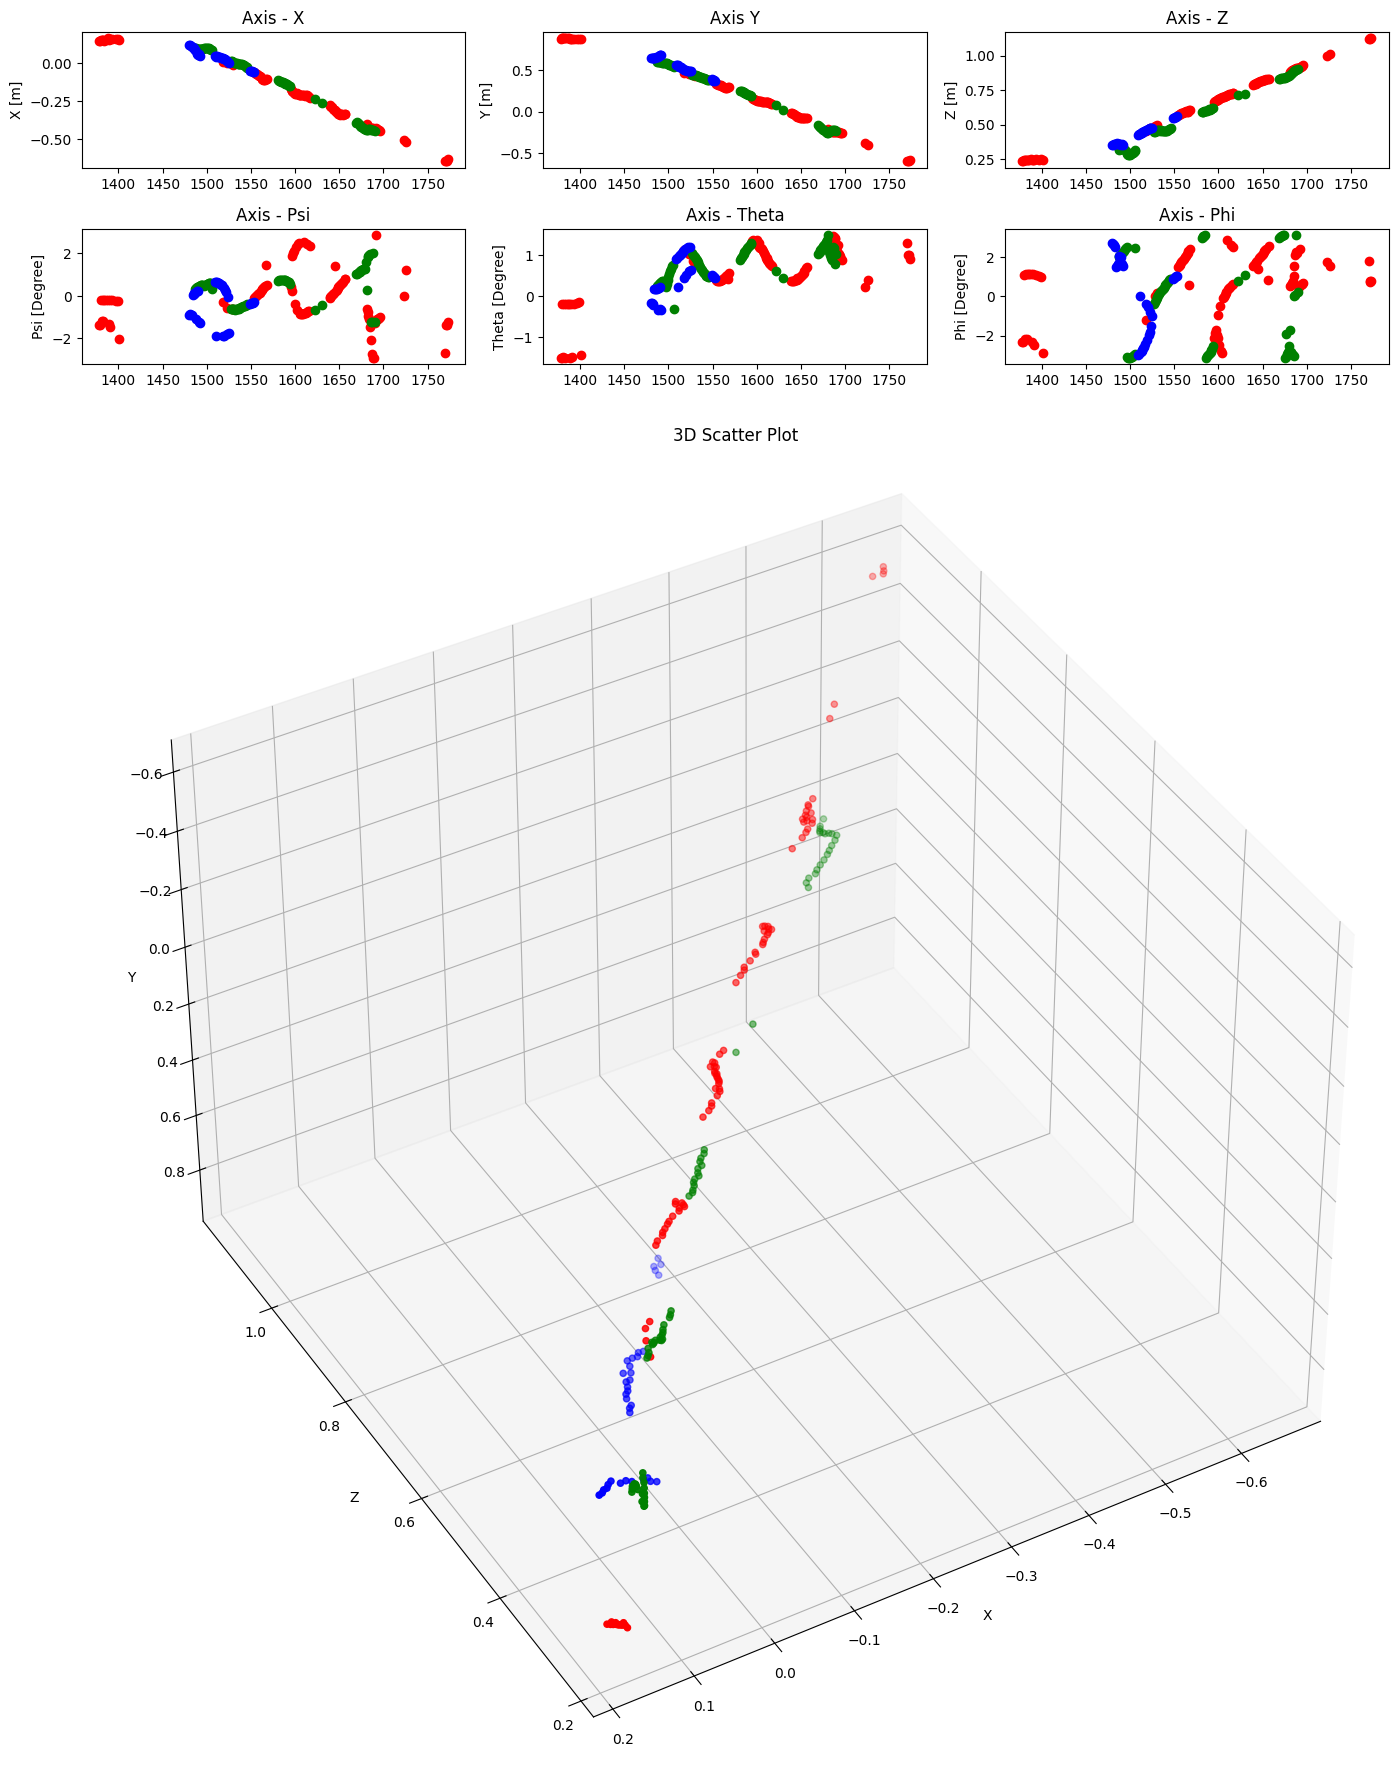

In [9]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

output_dir = './trajectories/vid220' #Path of the .txt file generated by main.py
files = sorted(glob.glob(os.path.join(output_dir, '*.txt')))
missing = []
DEFAULT_OFFSETS = [0, 93, 165]

# Read and concatenate all data into a list of DataFrames
dataframes = []
for csv, color in zip(files, ['r', 'g', 'b']): 
    df = pd.read_csv(csv, names=['filename', 'x', 'y', 'z', 'alpha', 'beta', 'gamma', 'center_x', 'center_y', 'rvec0', 'rvec1', 'rvec2', 'error', 'corners'], na_values=missing)
    df['color'] = color  # Add color column to differentiate datasets
    dataframes.append(df)

def update_plots(offset1=0, offset2=0, offset3=0):
    df1 = dataframes[0].copy()
    df2 = dataframes[1].copy()
    df3 = dataframes[2].copy()
    df1['cam'] = 'cam1'
    df2['cam'] = 'cam2'
    df3['cam'] = 'cam3'
    df1['adjusted_index'] = df1.index + offset1
    df2['adjusted_index'] = df2.index + offset2
    df3['adjusted_index'] = df3.index + offset3
    
    df_all = pd.concat([df1, df2, df3], ignore_index=True)
    
    df_all = df_all[(df_all['adjusted_index']> 1350) & (df_all['adjusted_index']< 1870)]
    fig = plt.figure(figsize=(14, 18))
    gs = fig.add_gridspec(3, 3, height_ratios=[0.1, 0.1, 1])

    
    ax1 = fig.add_subplot(gs[0, 0]) # Plot x
    for color in ['r', 'g', 'b']:
        subset = df_all[df_all['color'] == color]
        ax1.scatter(subset['adjusted_index'], subset['x'], c=color, label=color)
    ax1.set_ylabel('X [m]')
    ax1.set_title('Axis - X')
    
    
    ax2 = fig.add_subplot(gs[0, 1]) # Plot y
    for color in ['r', 'g', 'b']:
        subset = df_all[df_all['color'] == color]
        ax2.scatter(subset['adjusted_index'], subset['y'], c=color, label=color)
    ax2.set_ylabel('Y [m]')
    ax2.set_title('Axis Y')
    
    
    ax3 = fig.add_subplot(gs[0, 2]) # Plot z
    for color in ['r', 'g', 'b']:
        subset = df_all[df_all['color'] == color]
        ax3.scatter(subset['adjusted_index'], subset['z'], c=color, label=color)
    ax3.set_ylabel('Z [m]')
    ax3.set_title('Axis - Z')
    
    
    ax4 = fig.add_subplot(gs[1, 0]) # Plot Psi
    for color in ['r', 'g', 'b']:
        subset = df_all[df_all['color'] == color]
        ax4.scatter(subset['adjusted_index'], subset['alpha'], c=color, label=color)
    ax4.set_ylabel('Psi [Degree]')
    ax4.set_title('Axis - Psi')
    
    
    ax5 = fig.add_subplot(gs[1, 1]) # Plot Theta
    for color in ['r', 'g', 'b']:
        subset = df_all[df_all['color'] == color]
        ax5.scatter(subset['adjusted_index'], subset['beta'], c=color, label=color)
    ax5.set_ylabel('Theta [Degree]')
    ax5.set_title('Axis - Theta')
    
    ax6 = fig.add_subplot(gs[1, 2]) # Plot Phi
    for color in ['r', 'g', 'b']:
        subset = df_all[df_all['color'] == color]
        ax6.scatter(subset['adjusted_index'], subset['gamma'], c=color, label=color)
    ax6.set_ylabel('Phi [Degree]')
    ax6.set_title('Axis - Phi')
    
    ax7 = fig.add_subplot(gs[2, :], projection='3d')    # Plot 3D scatter
    for color in ['r', 'g', 'b']:
        subset = df_all[df_all['color'] == color]
        ax7.scatter(subset['x'], subset['z'], subset['y'], c=color, label=color)
    ax7.set_xlabel('X')
    ax7.set_ylabel('Z')
    ax7.set_zlabel('Y')
    ax7.set_title('3D Scatter Plot')
    ax7.view_init(-140, 120)
    
    plt.tight_layout()
    plt.show()

# Initial plot update with default offsets
update_plots(offset1=DEFAULT_OFFSETS[0], offset2=DEFAULT_OFFSETS[1], offset3=DEFAULT_OFFSETS[2])